# 多输出

参考：[Generate sub graphs from existing graph](https://discuss.tvm.apache.org/t/relay-generate-sub-graphs-from-existing-graph/11594/3)

In [1]:
from tvm import relay
from tvm.tir import IntImm
from tvm.ir import IRModule, structural_equal
from tvm.relay.op.annotation import compiler_begin, compiler_end


def set_func_attr(func, compile_name, symbol_name):
    func = func.with_attr("Primitive", IntImm("int32", 1))
    func = func.with_attr("Inline", IntImm("int32", 1))
    func = func.with_attr("Compiler", compile_name)
    func = func.with_attr("global_symbol", symbol_name)
    return func


def create_graph():
    data = relay.var("data", relay.TensorType((1, 3, 224, 224), "float32"))
    weight = relay.var("weight", relay.TensorType((16, 3, 3, 3), "float32"))
    bn_gamma = relay.var("bn_gamma", relay.TensorType((16,), "float32"))
    bn_beta = relay.var("bn_beta", relay.TensorType((16,), "float32"))
    bn_mean = relay.var("bn_mean", relay.TensorType((16,), "float32"))
    bn_var = relay.var("bn_var", relay.TensorType((16,), "float32"))

    data_cb = compiler_begin(data, "test_target")
    weight_cb = compiler_begin(weight, "test_target")
    bn_gamma_cb = compiler_begin(bn_gamma, "test_target")
    bn_beta_cb = compiler_begin(bn_beta, "test_target")
    bn_mean_cb = compiler_begin(bn_mean, "test_target")
    bn_var_cb = compiler_begin(bn_var, "test_target")

    conv_o = relay.nn.conv2d(data=data_cb,
                             weight=weight_cb,
                             kernel_size=(3, 3),
                             channels=16,
                             padding=(1, 1))

    bn_o = relay.nn.batch_norm(conv_o,
                               bn_gamma_cb,
                               bn_beta_cb,
                               bn_mean_cb,
                               bn_var_cb)

    relu_o = relay.nn.relu(bn_o[0])
    relu_o_ce = compiler_end(relu_o, "test_target")

    bn_omean = bn_o[1]
    rebn_omean_ce = compiler_end(bn_omean, "test_target")
    bn_ovar = bn_o[2]
    bn_ovar_ce = compiler_end(bn_ovar, "test_target")
    dummy_mean_abs = relay.abs(rebn_omean_ce)
    dummy_ovar_abs = relay.abs(bn_ovar_ce)
    dummy_tuple = relay.Tuple((relu_o_ce,
                               dummy_mean_abs,
                               dummy_ovar_abs))

    func = relay.Function([data,
                           weight,
                           bn_gamma,
                           bn_beta,
                           bn_mean,
                           bn_var],
                          dummy_tuple)
    return func


def expected():
    mod = IRModule()
    # function 0
    data = relay.var("test_target_0_i0", relay.TensorType(
        (1, 3, 224, 224), "float32"))
    weight = relay.var("test_target_0_i1",
                       relay.TensorType((16, 3, 3, 3), "float32"))
    bn_gamma = relay.var("test_target_0_i2",
                         relay.TensorType((16,), "float32"))
    bn_beta = relay.var("test_target_0_i3",
                        relay.TensorType((16,), "float32"))
    bn_mean = relay.var("test_target_0_i4",
                        relay.TensorType((16,), "float32"))
    bn_var = relay.var("test_target_0_i5",
                       relay.TensorType((16,), "float32"))

    conv_o = relay.nn.conv2d(
        data=data,
        weight=weight,
        kernel_size=(3, 3),
        channels=16,
        padding=(1, 1)
    )

    bn_o = relay.nn.batch_norm(conv_o, bn_gamma, bn_beta, bn_mean, bn_var)

    relu_o = relay.nn.relu(bn_o[0])
    tuple_o = relay.Tuple((relu_o, bn_o[1], bn_o[2]))

    func0 = relay.Function(
        [data, weight, bn_gamma, bn_beta, bn_mean, bn_var], tuple_o)
    func0 = set_func_attr(func0, "test_target",
                          "tvmgen_default_test_target_main_0")
    gv0 = relay.GlobalVar("tvmgen_default_test_target_main_0")
    mod[gv0] = func0
    mod = relay.transform.InferType()(mod)

    # body
    data = relay.var("data", relay.TensorType((1, 3, 224, 224), "float32"))
    weight = relay.var("weight", relay.TensorType(
        (16, 3, 3, 3), "float32"))
    bn_gamma = relay.var("bn_gamma", relay.TensorType((16,), "float32"))
    bn_beta = relay.var("bn_beta", relay.TensorType((16,), "float32"))
    bn_mean = relay.var("bn_mean", relay.TensorType((16,), "float32"))
    bn_var = relay.var("bn_var", relay.TensorType((16,), "float32"))

    f0_o = gv0(data, weight, bn_gamma, bn_beta, bn_mean, bn_var)
    f0_relu_o = relay.TupleGetItem(f0_o, 0)
    f0_mean_o = relay.TupleGetItem(f0_o, 1)
    f0_var_o = relay.TupleGetItem(f0_o, 2)

    f0_mean_abs = relay.abs(f0_mean_o)
    f0_var_abs = relay.abs(f0_var_o)
    main_tuple = relay.Tuple((f0_relu_o, f0_mean_abs, f0_var_abs))

    func = relay.Function(
        [data, weight, bn_gamma, bn_beta, bn_mean, bn_var], main_tuple)
    mod["main"] = func
    mod = relay.transform.InferType()(mod)
    return mod


In [2]:
mod = IRModule()
mod["main"] = create_graph()
ref_mod = expected()

partitioned = relay.transform.PartitionGraph()(mod)
assert structural_equal(partitioned, ref_mod, map_free_vars=True)

In [5]:
from tvm_book.testing.relay.viz import graphviz_relay

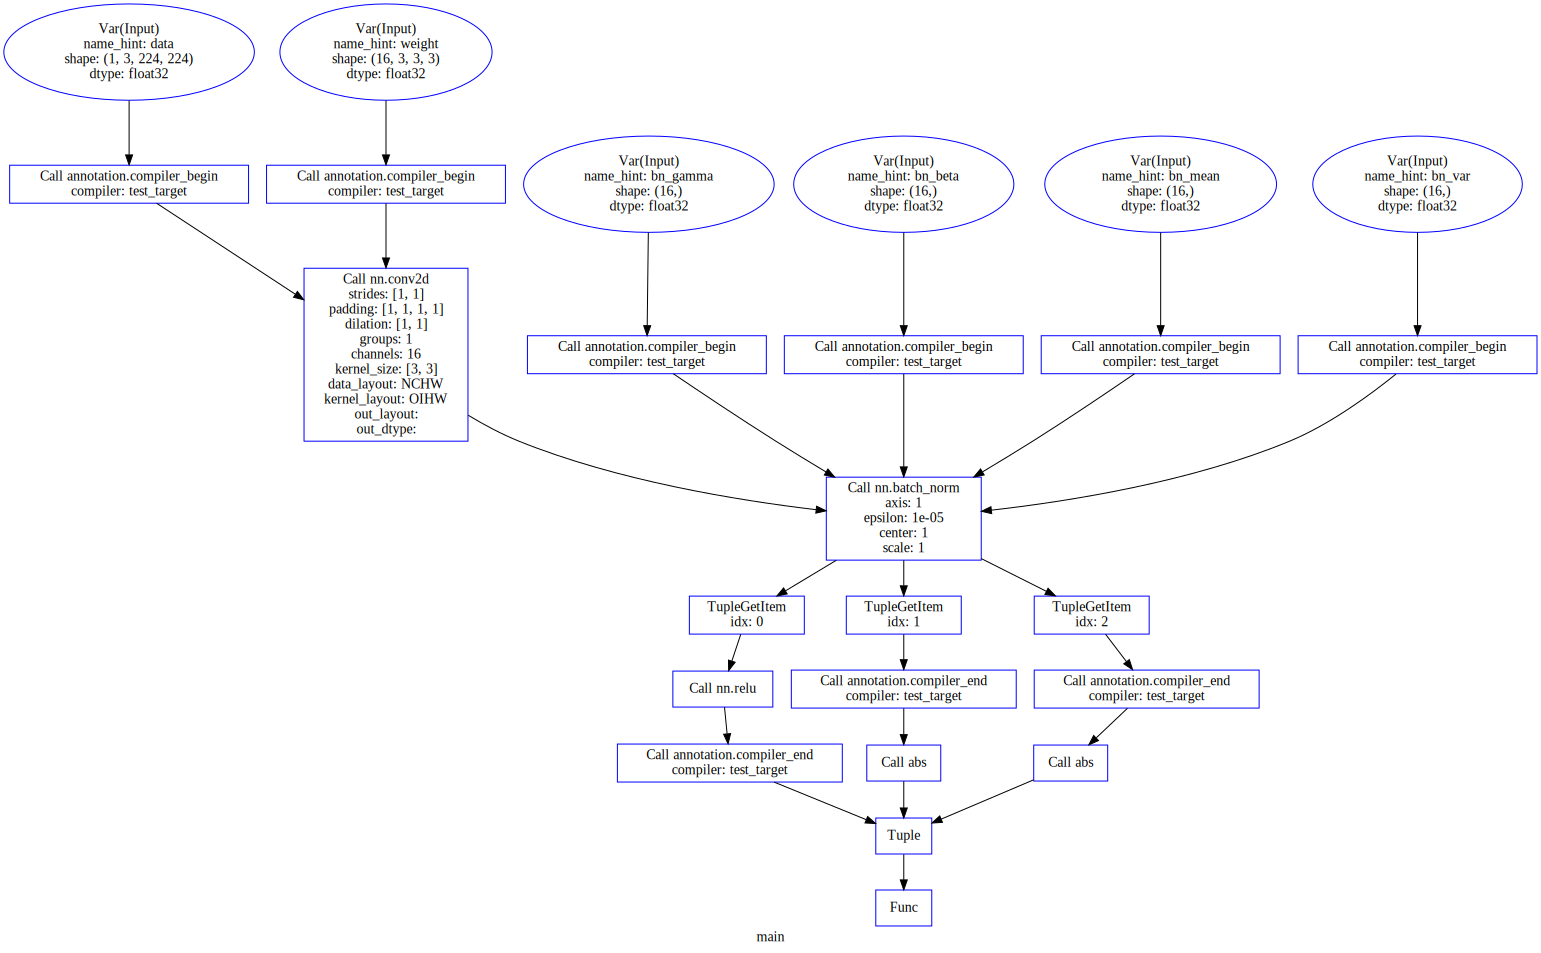

In [8]:
graphviz_relay(mod, "main")

In [10]:
partitioned.get_global_vars()

[GlobalVar(main), GlobalVar(tvmgen_default_test_target_main_0)]

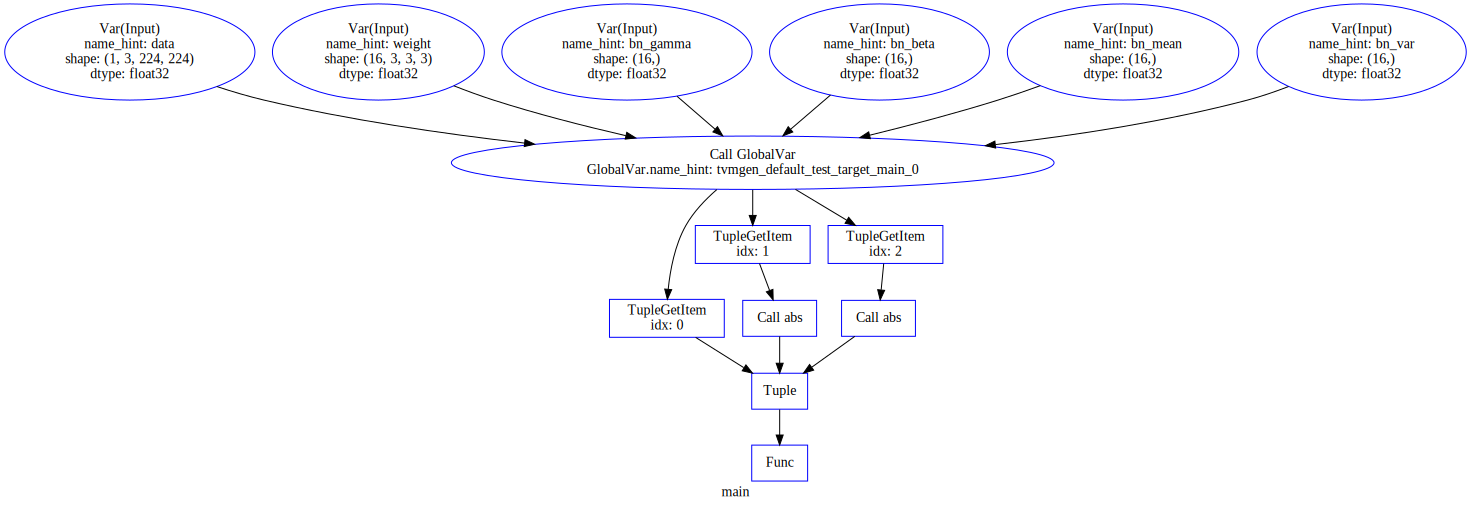

In [6]:
graphviz_relay(partitioned, "main")

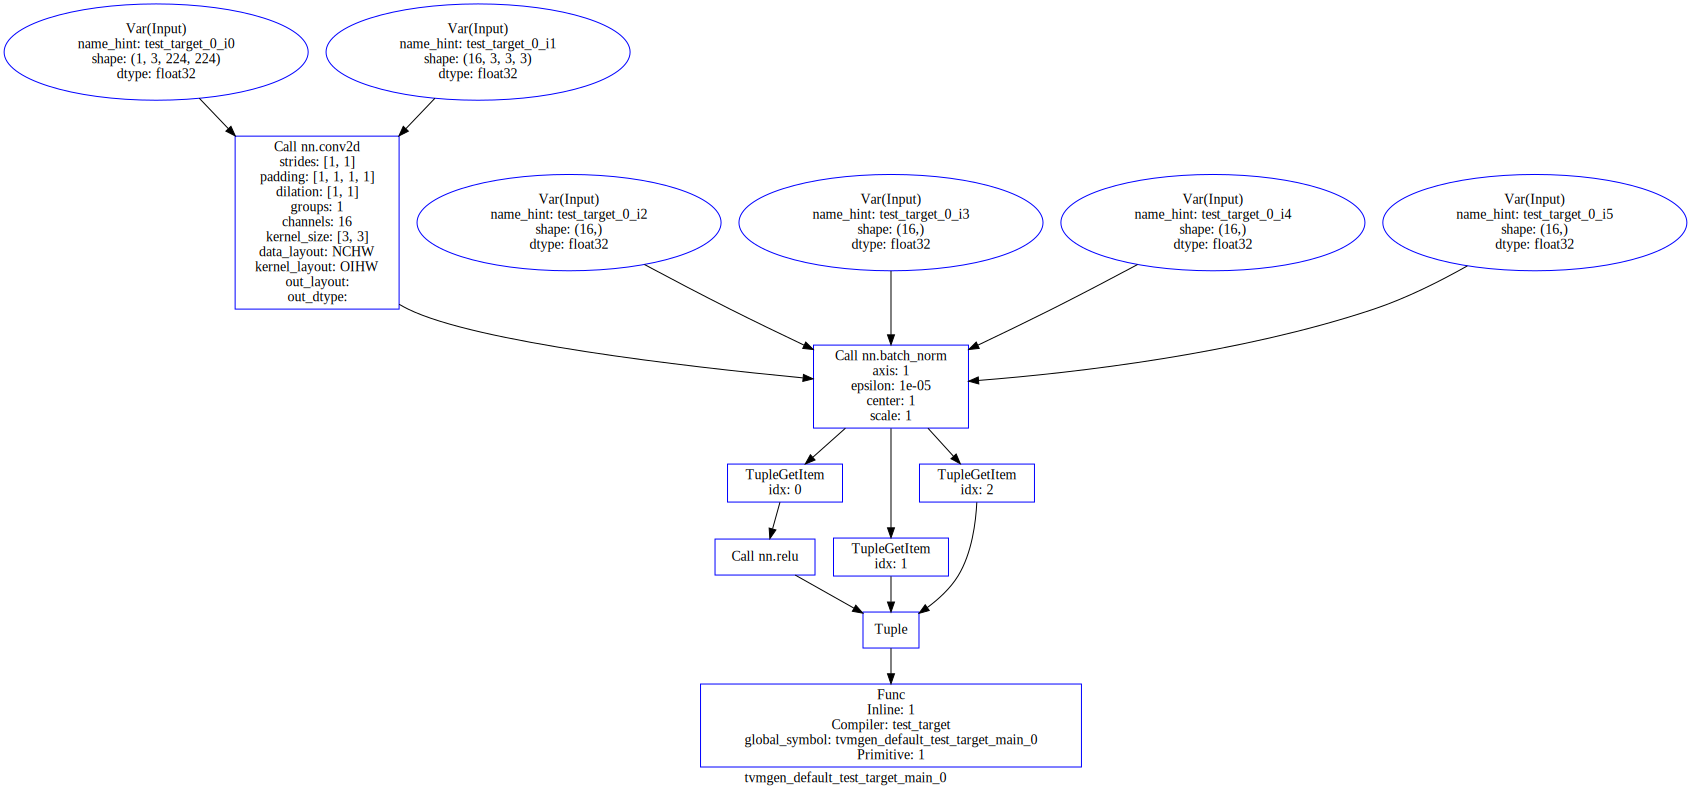

In [11]:
graphviz_relay(partitioned, "tvmgen_default_test_target_main_0")

In [ ]:
graphviz_relay(partitioned, "main")

In [17]:
import numpy as np

import tvm
from tvm.relay.backend import te_compiler
from tvm.relay.backend.runtime import Runtime
import tvm.relay.testing
import tvm.relay.op as reg
from tvm import relay
from tvm import runtime as tvm_runtime
from tvm.relay import transform
from tvm.relay.testing import byoc
from tvm.contrib import utils
from tvm.relay.expr_functor import ExprMutator
from tvm.relay.op.annotation import compiler_begin, compiler_end
from tvm.relay.op.contrib.register import get_pattern_table
from tvm.relay.build_module import bind_params_by_name

# Leverage the pass manager to write a simple allowed list based annotator
@transform.function_pass(opt_level=0)
class AllowedListAnnotator:
    def __init__(self, op_list, compiler):
        assert isinstance(op_list, (list, tuple, set))
        self.op_list = op_list
        self.compiler = compiler

    def transform_function(self, func, mod, dev):

        annotator = self

        class Annotator(tvm.relay.ExprMutator):
            def visit_call(self, call):
                op_name = call.op.name
                if op_name in annotator.op_list:
                    new_args = []
                    for arg in call.args:
                        ann = compiler_begin(super().visit(arg), annotator.compiler)
                        new_args.append(ann)
                    new_call = relay.Call(call.op, new_args, call.attrs, call.type_args)
                    return compiler_end(new_call, annotator.compiler)
                else:
                    return super().visit_call(call)

        return Annotator().visit(func)

In [21]:
def create_graph():
    data = relay.var("data", shape=(10, 10))

    cb_1 = compiler_begin(data, "test_target")
    O_1 = relay.abs(cb_1)
    ce_2 = compiler_end(O_1, "test_target")
    O_2 = relay.nn.relu(O_1)
    ce_3 = compiler_end(O_2, "test_target")

    X = relay.tanh(ce_2)

    cb_3 = compiler_begin(ce_3, "test_target")
    cb_4 = compiler_begin(X, "test_target")
    O_3 = relay.add(cb_3, cb_4)
    ce_4 = compiler_end(O_3, "test_target")

    func = relay.Function([data], ce_4)
    return func

def expected():
    mod = tvm.IRModule()

    # function 1
    f1_cb1 = relay.var("test_target_0_i0", shape=(10, 10))
    f1_O_1 = relay.abs(f1_cb1)
    f1_O_2 = relay.nn.relu(f1_O_1)
    f1_out = relay.Tuple((f1_O_2, f1_O_1))
    func1 = relay.Function([f1_cb1], f1_out)
    func1 = set_func_attr(func1, "test_target", "tvmgen_default_test_target_main_0")
    gv1 = relay.GlobalVar("tvmgen_default_test_target_main_0")
    mod[gv1] = func1
    mod = relay.transform.InferType()(mod)

    # function 0
    f2_cb3 = relay.var("test_target_1_i0", shape=(10, 10))
    f2_cb4 = relay.var("test_target_1_i1", shape=(10, 10))
    f2_O_3 = relay.add(f2_cb3, f2_cb4)
    func0 = relay.Function([f2_cb3, f2_cb4], f2_O_3)
    func0 = set_func_attr(func0, "test_target", "tvmgen_default_test_target_main_1")
    gv0 = relay.GlobalVar("tvmgen_default_test_target_main_1")
    mod[gv0] = func0
    mod = relay.transform.InferType()(mod)

    # body
    data = relay.var("data", shape=(10, 10))
    tuple_out = gv1(data)
    ce_2 = relay.TupleGetItem(tuple_out, 1)
    ce_3 = relay.TupleGetItem(tuple_out, 0)

    X = relay.tanh(ce_2)
    ce_4 = gv0(ce_3, X)
    func = relay.Function([data], ce_4)
    mod["main"] = func
    mod = relay.transform.InferType()(mod)
    return mod

mod = tvm.IRModule()
mod["main"] = create_graph()
mod = transform.InferType()(mod)

ref_mod = expected()

partitioned = transform.PartitionGraph()(mod)
assert tvm.ir.structural_equal(partitioned, ref_mod, map_free_vars=True)

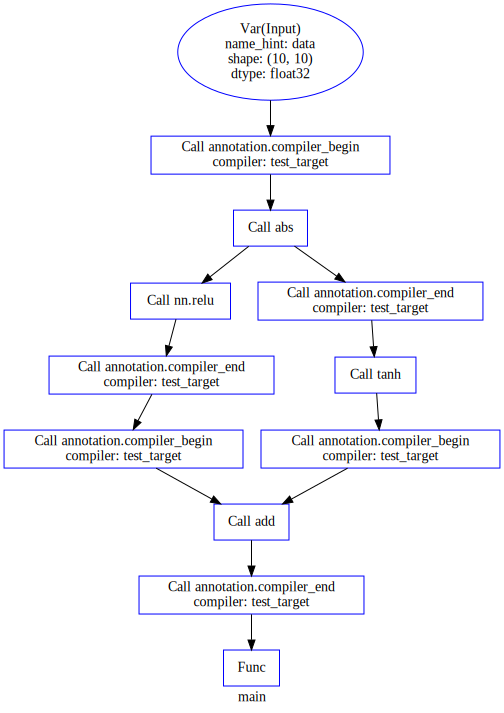

In [23]:
graphviz_relay(mod, "main")

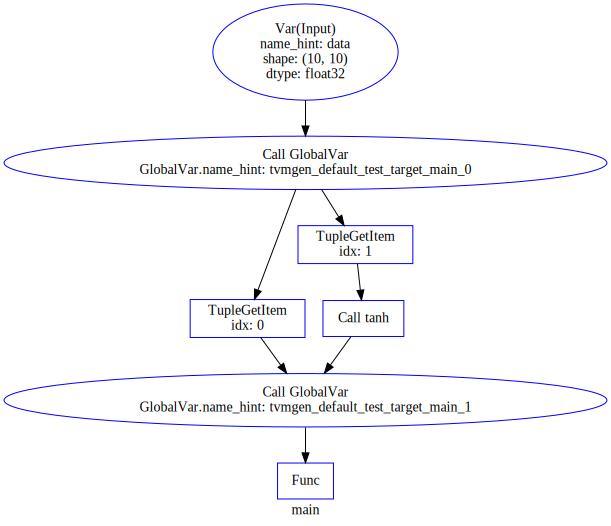

In [24]:
graphviz_relay(partitioned, "main")